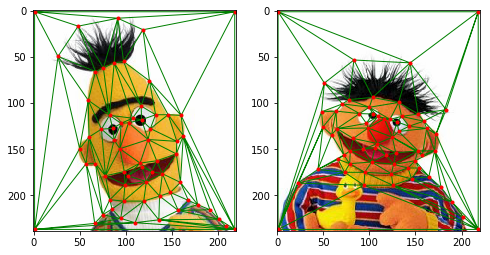

# Trip Generation


In this assignment, you will develop a function to Trip Generate. As with previous assignments, you should avoid writing any code that explicitly loops over pixels in the image.

---

## Part 1) Extract CSV
---

In [19]:
import csv

students = set([])
trips = set([])
prefs = {}
indices = {}

FIRST_NAME = 'First Name'
LAST_NAME = 'Last Name'
FIRST_CHOICE = 'First Choice Field Trip'
SECOND_CHOICE = 'Second Choice Field Trip'
THIRD_CHOICE = 'Third Choice Field Trip'
FOURTH_CHOICE = 'Fourth Choice Field Trip'
FIFTH_CHOICE = 'Fifth Choice Field Trip'

with open('fall_19.csv') as file: # , newline=''
    reader = csv.reader(file, delimiter=',', quotechar='|')
    for i, row in enumerate(reader):
        # print(row)
        if i == 0:
            for j, title in enumerate(row):
                # print(j, title)
                indices[title] = j
        if i > 0:
            # print('row', row)
            # print(indices[FIRST_CHOICE])
            student = row[indices[FIRST_NAME]] + row[indices[LAST_NAME]]
            prefs[student] = tuple([
                row[indices[FIRST_CHOICE]],
                row[indices[SECOND_CHOICE]],
                row[indices[THIRD_CHOICE]],
                row[indices[FOURTH_CHOICE]],
                row[indices[FIFTH_CHOICE]],
            ])
            students.add(student)
            for t in prefs[student]:
                trips.add(t)
    # print(prefs)
    trips = sorted(list(trips))
    print(trips)

['Bay Area Home Electrification Expo  Sat. Oct. 12  9am-5pm', 'Diablo Canyon Nuclear Power Plant  Tue. Nov. 5  6:15am-6:30pm', 'Moss Landing Natural Gas Power Plant & Battery Project  Tue. Oct. 29  7am-1:30pm', 'PG&E Pacific Energy Center  Tue. Nov. 27  6:55am-1pm', 'PG&E Pacific Energy Center  Wed. Nov. 20  6:50am-1pm', 'PG&E Pacific Energy Center  Wed. Nov. 22  6:50am-1pm', 'San Ardo Oil Field  Thu. Oct. 17  6:45am-5pm', 'Shasta Dam & Hydroelectric Power Plant  Sat. Nov. 16  6:45am-7pm']


### Part 2) Scoring Function

---


In [93]:
import numpy as np
TRIP_MAX = 2
TRIP_PPL_MAX = np.array([21,21,21,21,21,21,21,21])
STARTING_SCORE = 10
SCORE_DECAY_FACTOR = 0.5
SINGLE_TRIP_FACTOR = 1.5
MAX_NUM_TRIPS = len(trips)
SCORE_WEIGHTS_2 = [STARTING_SCORE * SCORE_DECAY_FACTOR ** i for i in range(MAX_NUM_TRIPS)]
SCORE_WEIGHTS_1 = [SINGLE_TRIP_FACTOR * STARTING_SCORE * SCORE_DECAY_FACTOR ** i for i in range(MAX_NUM_TRIPS)]
CAPACITY_PENALTY_FACTOR = 20
PER_STUDENT_PENALTY_FACTOR = np.sum(np.array(SCORE_WEIGHTS_2)) + 5
print(PER_STUDENT_PENALTY_FACTOR)

def make_pref_matrix(prefs):
    mat = np.zeros((len(students), MAX_NUM_TRIPS))
    for row, (student, prefs) in enumerate(prefs.items()):
        # print('student', student)
        for col, pref in enumerate(prefs):
            prefIndex = trips.index(pref)
            mat[row][prefIndex] = SCORE_WEIGHTS_2[col]
            # print('r:', row, 'c:', col, 'pref:', pref, prefIndex)
        # print(mat[row])
    return mat

def score_matrix(pref_mat, assignment_mat, debug=False):
    trip_score = np.sum(np.sum(np.multiply(pref_mat, assignment_mat)))

    diff = (np.sum(assignment_mat, axis=0) - TRIP_PPL_MAX)
    zero = np.zeros(assignment_mat.shape[1])
    capacity_penalty = CAPACITY_PENALTY_FACTOR * np.maximum(diff, zero).sum()

    diff = (np.sum(assignment_mat, axis=1) - TRIP_MAX)
    zero = np.zeros(assignment_mat.shape[0])
    per_student_penalty = PER_STUDENT_PENALTY_FACTOR * np.maximum(diff, zero).sum()
    if debug:
        print('assignment', assignment_mat)
        print('per_student', np.maximum(diff, zero))
    # print(trip_score, capacity_penalty, per_student_penalty)
    return trip_score - capacity_penalty - per_student_penalty  

def evaluate_matrix(pref_mat, assignment_mat):
    trip_score = np.sum(np.sum(np.multiply(pref_mat, assignment_mat)))
    students_on_each_trip = np.sum(assignment_mat, axis=0)
    trips_per_student = np.sum(assignment_mat, axis=1)
    print('\nTotal trip score:', trip_score)
    print('\nStudent on each trip', students_on_each_trip)
    print('\nTrips per student:', trips_per_student)

def score_student(prefs, trips):
    """ Calculates score for single student given trip assignment.
    """
    total = 0
    for pref, score in zip(prefs, SCORE_WEIGHTS_2):
        if pref in trips:
            total += score
    return total

def score_students(prefs, assignments):
    """ Calculates score for assignment for whole class
    """
    total = 0
    for student, pref in prefs.items():
        total += score_student(pref, assignments[student])
    return total
pref_mat = make_pref_matrix(prefs)

24.921875


### Part 3) Make assignment

---

running mutation_rate with rate: sss


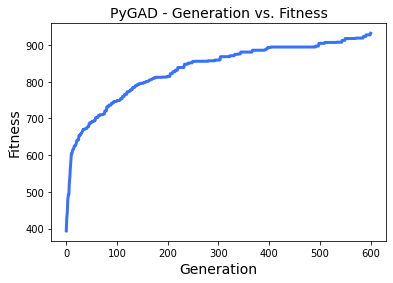

got fitness: 931.875


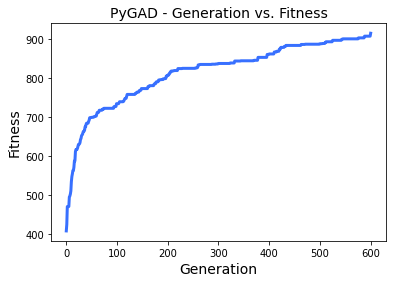

got fitness: 914.375
running mutation_rate with rate: tournament


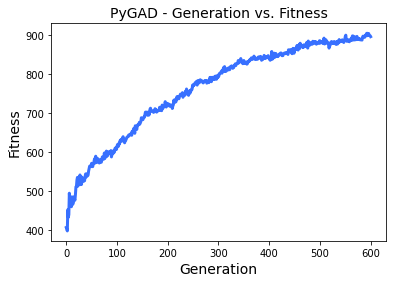

got fitness: 896.25


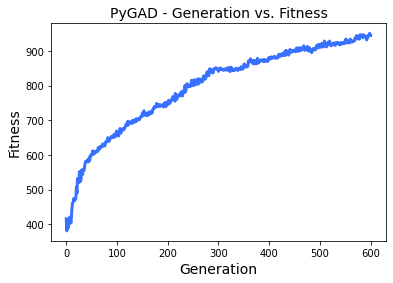

got fitness: 945.0
running mutation_rate with rate: sus


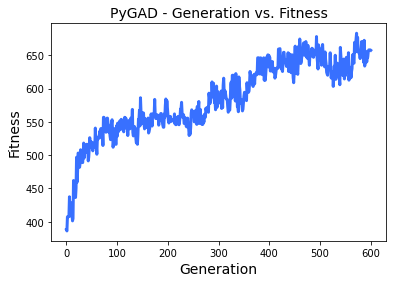

got fitness: 657.5


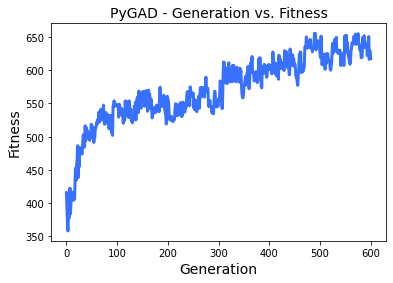

got fitness: 617.578125
grid [(['sss', 923.125], [931.875, 914.375]), (['tournament', 920.625], [896.25, 945.0]), (['sus', 637.5390625], [657.5, 617.578125])]

Total trip score: 642.5

Student on each trip [19. 20. 19. 19. 17. 17. 21. 18.]

Trips per student: [1. 1. 2. 2. 0. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 3. 2. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0.

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import pygad

GA_POPULATION = 1000
NUM_PARENTS_MATING = GA_POPULATION // 10
N_GENERATIONS = 600
PARENT_SELECTION_TYPE = "sss"
MUTATE_FRACTION = len(students) * MAX_NUM_TRIPS * 7.71604938e-6

def get_random_assignment():
    assignments = np.full((len(students), MAX_NUM_TRIPS), False)
    for row in assignments:
        # continue
        two = np.random.permutation(assignments.shape[1])[:5]
        row[two[0]] = True
        row[two[1]] = True
    return assignments
def genetic_solve(num_generations, eval_point, parent_type):
    pref_mat = make_pref_matrix(prefs)
    def fitness_func(solution, solution_idx):
        return score_matrix(pref_mat, np.reshape(solution, (-1, pref_mat.shape[1])), debug=False)

    points = []
    for _ in range(GA_POPULATION):
        points.append(get_random_assignment().flatten())

    def callback_generation(ga_instance):
        if ga_instance.generations_completed % (N_GENERATIONS/10) == 0:
            return
            print('first few lines:', ga_instance.best_solution()[0][:25])
            print("Generation = {generation}".format(generation=ga_instance.generations_completed))
            print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
            # print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
            # last_fitness = ga_instance.best_solution()[1]
    
    def mutation_func(offspring, ga_instance):
        
        for row in range(offspring.shape[0]):
            num_to_mutate = int(offspring[row].size * MUTATE_FRACTION / 2)
            random_gene_indexes = np.random.randint(0, offspring[row].size, num_to_mutate)
            # print('a',random_gene_indexes)
            # print('b', offspring[row, random_gene_indexes])
            offspring[row, random_gene_indexes] = 1
            random_gene_indexes = np.random.randint(0, offspring[row].size, num_to_mutate)
            offspring[row, random_gene_indexes] = 0
            
        return offspring
    # Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=NUM_PARENTS_MATING, 
                        fitness_func=fitness_func,
                        # sol_per_pop=sol_per_pop, 
                        # num_genes=num_genes,
                        on_generation=callback_generation,
                        parent_selection_type=parent_type,
                        initial_population=points,
                        # mutation_probability=1,
                        mutation_type=mutation_func,
                        # init_range_low=0, # This and below parameters limit genes to binary
                        # init_range_high=2,
                        # random_mutation_min_val=0,
                        # random_mutation_max_val=2,
                        # mutation_by_replacement=True,
                        # gene_type=int)
                        )

    # Running the GA to optimize the parameters of the function.
    ga_instance.run()

    # After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
    ga_instance.plot_fitness()

    # Returning the details of the best solution.
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    # FIXME: uncomment        
    # print("Parameters of the best solution : {solution}".format(solution=np.reshape(solution, (-1, pref_mat.shape[1]))))
    # print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    # print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
    # if ga_instance.best_solution_generation != -1:
    #     print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))
    return ga_instance.best_solution()

mutation_rates = ['sss', 'tournament', 'sus']
def optimizeGA(objective, descent):
    pref_mat = make_pref_matrix(prefs)

    grid = []
    for mutation_rate in mutation_rates:
        print('running mutation_rate with rate:', mutation_rate)
        l = []
        for i in range(2):
            solution, solution_fitness, solution_idx = descent(N_GENERATIONS, objective, mutation_rate)
            l.append(solution_fitness)
            print('got fitness:', solution_fitness)
        avg = sum(l)/len(l)
        grid.append(([mutation_rate, avg], l))
    print('grid', grid)
    evaluate_matrix(pref_mat, np.reshape(solution, (-1, pref_mat.shape[1])))
    return solution, solution_fitness
h1 = (optimizeGA(score_matrix, genetic_solve))
h0=["Step Sizes"]
h0.append("Minimum")
h0.append("Time List")
h0.append("Number of evals")
print(h1)
print(make_pref_matrix(prefs))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

def get_random_assignment():
    assignments = np.full((len(students), MAX_NUM_TRIPS), False)
    for row in assignments:
        two = np.random.permutation(assignments.shape[0])[:2]



    trips = np.array(['A', 'B', 'C', 'D', 'E'])
    assignments = {}
    for student in prefs.keys():
        assignments[student] = list(np.random.permutation(trips)[:2])
    return assignments
print(score_students(prefs, get_random_assignment()))
print(SCORE_WEIGHTS_1)

def pick_random_element(arr):
    return list(arr)[random.randrange(0, len(arr))]

def swap_assigns(assign1, assign2):
    while True:
        trip1 = pick_random_element(assign1)
        trip2 = pick_random_element(assign2)
        if trip1 == trip2:
            continue
        if trip1 in assign2 or trip2 in assign1:
            continue
        assign1.remove(trip1)
        assign2.append(trip1)
        assign2.remove(trip2)
        assign1.append(trip2)
        return(assign1, assign2)

def optimize(assignments, iters=1e4, max_attempts=1e4):
    # print('AAAAAA', score_students(prefs, assignments))
    scores = [score_students(prefs, assignments)]
    swaps = 0
    print(assignments)
    attempts = 0
    while swaps < iters:
        attempts += 1
        if attempts > max_attempts:
            break
        first = pick_random_element(students)
        second = pick_random_element(students)
        scoreBefore = (score_student(prefs[first], assignments[first])
                    + score_student(prefs[second], assignments[second]))
        if first == second:
            continue
        assign1 = copy.deepcopy(assignments[first])
        assign2 = copy.deepcopy(assignments[second])
        if set(assign1) == set(assign2):
            continue
        # print('a1', assign1, 'a2', assign2)
        assign1, assign2 = swap_assigns(assign1, assign2)
        # print('a1', assign1, 'a2', assign2)
        scoreAfter = (score_student(prefs[first], assign1)
                    + score_student(prefs[second], assign2))
        if scoreBefore >= scoreAfter:
            continue
        print('before', scoreBefore, 'after', scoreAfter)
        # print('b', first, second, assignments[first], assign1, assignments[second], assign2)
        # print('assignments before', assignments)
        assignments[first] = assign1
        # print('a', assignments[first])
        assignments[second] = assign2
        # print('assignments after', assignments)
        scores.append(score_students(prefs, assignments))
        attempts = 0
        swaps += 1
    return assignments, scores

assignments, scores = optimize(get_random_assignment(), iters=100)
plt.plot(scores)
plt.show()

print(assignments)
